### CIFAR10으로 pytorch 공부하기
- 본 노트북은 로컬환경이 아닌 코랩에서 실행되었음 (버전 및 쿠다 주의)
- MNIST랑 같은 이미지분류
- 다른점은 칼라(채널 3), 레이블이 10종류라는 점
- reference : https://www.youtube.com/watch?v=lh2Ed-b5l28&list=PLSAJwo7mw8jn8iaXwT4MqLbZnS-LJwnBd&index=14
> - 모델 아키텍처부분이랑 def experiment 이 부분의 아이디어 위주로 참고하면 됨!

In [1]:
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)

ERROR: Could not find a version that satisfies the requirement torch==1.0.0 (from versions: 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1)
ERROR: No matching distribution found for torch==1.0.0
1.13.0+cu116


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np

## Data Preparation

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=4, 
                                        shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2) # valid, test는 섞지않는다!!

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


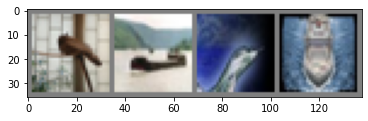

 bird  ship plane  ship
<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([4]) tensor([2, 8, 0, 8])


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

print(type(images), images.shape) # 이미지가 하나에 32*32*3(채널) 크기임. 그리고 배치 하나당 4개씩 이미지 갖게됨. # 즉 input dim은 32*32*3
print(type(labels), labels.shape, labels)

> - 이미지가 하나에 32*32*3(채널) 크기임. 그리고 배치 하나당 4개씩 이미지 갖게됨.
> - 즉 input dim은 32*32*3

## Model Architecture

In [5]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_hid_layer, active_func):
        super(MLP, self).__init__()
        # init이 아닌 다른 함수에서 쓰이는 경우를 위해 self 쓰는거.
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_hid_layer = n_hid_layer
        self.act = active_func
        
        self.in_mlp = nn.Linear(self.in_dim, self.hid_dim)
        self.mlps = nn.ModuleList()
        
        for i in range(self.n_hid_layer):
            self.mlps.append(nn.Linear(self.hid_dim, self.hid_dim))
        
        self.out_mlp = nn.Linear(self.hid_dim, self.out_dim)
        
        if self.act == 'relu':
            self.act = nn.ReLU()
          
    def forward(self, x):
        x = self.act(self.in_mlp(x))
        for hidden_mlp in self.mlps:
            x = self.act(hidden_mlp(x))
        x = self.out_mlp(x) # 마지막엔 활성화함수 적용x !
        return x

In [6]:
model = MLP(in_dim = 3072, out_dim = 10, hid_dim = 100, n_hid_layer = 3, active_func = 'relu')

print(model) # 시험삼아 확인해보기 (추후 밑에서 args 설정해서 호출할것임)

MLP(
  (in_mlp): Linear(in_features=3072, out_features=100, bias=True)
  (mlps): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (out_mlp): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)


## Define Experiment

In [7]:
def experiment(args):
  
    model = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_hid_layer, args.active_func)
    model.cuda()
    print(model)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.mm)
    
    for epoch in range(args.epoch):  # loop over the dataset multiple times

        # ==== Train ===== #
        model.train()
        
        running_loss = 0.0
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            optimizer.zero_grad()

            inputs, labels = data # inputs : [4,3,32,32] 이 형태라서 우리가 설정한 크기와 다름!
            inputs = inputs.view(-1, 3072) # inputs : [4, 3072]
            
            inputs = inputs.cuda()
            labels = labels.cuda()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            train_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
                

        # ==== Validation ====== #
        model.eval()
        # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Validation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
        
        correct = 0
        total = 0
        val_loss = 0 
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images = images.view(-1, 3072)
                
                images = images.cuda()
                labels = labels.cuda()
                
                outputs = model(images)

                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_loss = val_loss / len(valloader)
            val_acc = 100 * correct / total
            
        print('Epoch {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch, train_loss, val_loss, val_acc ))


    # ===== Evaluation ===== # #(이러면 모든 에폭마다 다 검증하는셈일거야)
    model.eval()    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
            
    return train_loss, val_loss, val_acc, test_acc
    

## Experiment

In [8]:
import time

start = time.time()

In [9]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")


args.n_hid_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.active_func = 'relu'

args.lr = 0.001
args.mm = 0.9
args.epoch = 2

# 그리드하게 테스트하는거임
list_var1 = [4, 5, 6]
list_var2 = [50, 100, 150]

for var1 in list_var1:
    for var2 in list_var2:
        args.n_layer = var1
        args.hid_dim = var2
        result = experiment(args)
        print(result)

MLP(
  (in_mlp): Linear(in_features=3072, out_features=50, bias=True)
  (mlps): ModuleList(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
  )
  (out_mlp): Linear(in_features=50, out_features=10, bias=True)
  (act): ReLU()
)
[1,  2000] loss: 2.302
[1,  4000] loss: 2.223
[1,  6000] loss: 2.036
[1,  8000] loss: 1.980
[1, 10000] loss: 1.892
Epoch 0, Train Loss: 20866.50378137827, Val Loss: 1.8569657981395722, Val Acc: 28.16
[2,  2000] loss: 1.844
[2,  4000] loss: 1.805
[2,  6000] loss: 1.779
[2,  8000] loss: 1.732
[2, 10000] loss: 1.684
Epoch 1, Train Loss: 17688.13314527273, Val Loss: 1.695641452217102, Val Acc: 37.27
(17688.13314527273, 1.695641452217102, 37.27, 38.72)
MLP(
  (in_mlp): Linear(in_features=3072, out_features=100, bias=True)

In [10]:
time_cost = time.time() - start
print(f'colab gpu 기준 소요시간 : {time_cost/60}분')

colab gpu 기준 소요시간 : 16.407117370764414분
